In [1]:
# pip install pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Bank Marketing Analysis") \
    .getOrCreate()


In [3]:
df = spark.read.csv("bank-full.csv", header=True, inferSchema=True)
df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [4]:
df.show(5)  # Preview
df.describe().show()  # Summary stats

# Count total rows
print("Total Rows:", df.count())

# Column types
df.dtypes


+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar|married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown| single|  unknown|     no|      1|     no|  no|unknown|  5|  may|     19

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string')]

In [5]:
from pyspark.sql.functions import col, sum

missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()


+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



In [6]:
# Example: Count by job type
df.groupBy("job").count().orderBy("count", ascending=False).show()

# Example: Average balance by education
df.groupBy("education").avg("balance").show()


+-------------+-----+
|          job|count|
+-------------+-----+
|  blue-collar| 9732|
|   management| 9458|
|   technician| 7597|
|       admin.| 5171|
|     services| 4154|
|      retired| 2264|
|self-employed| 1579|
| entrepreneur| 1487|
|   unemployed| 1303|
|    housemaid| 1240|
|      student|  938|
|      unknown|  288|
+-------------+-----+

+---------+------------------+
|education|      avg(balance)|
+---------+------------------+
|  unknown|1526.7544426494346|
| tertiary|1758.4164348545223|
|secondary| 1154.880786139126|
|  primary|1250.9499343161583|
+---------+------------------+



In [7]:
print("TOP 5 JOBS")
df.groupBy("job").count().orderBy("count", ascending=False).limit(5).show()

TOP 5 JOBS


+-----------+-----+
|        job|count|
+-----------+-----+
|blue-collar| 9732|
| management| 9458|
| technician| 7597|
|     admin.| 5171|
|   services| 4154|
+-----------+-----+



In [8]:
from pyspark.sql.functions import round, count

total_count = df.count()
df.groupBy("marital").agg(
    round((count("*") / total_count) * 100, 2).alias("percentage")
).orderBy("percentage", ascending=False).show()


+--------+----------+
| marital|percentage|
+--------+----------+
| married|     60.19|
|  single|     28.29|
|divorced|     11.52|
+--------+----------+



In [9]:
df.groupBy("job", "marital").count().orderBy("count", ascending=False).show()

+-------------+--------+-----+
|          job| marital|count|
+-------------+--------+-----+
|  blue-collar| married| 6968|
|   management| married| 5400|
|   technician| married| 4052|
|   management|  single| 2947|
|       admin.| married| 2693|
|   technician|  single| 2620|
|     services| married| 2407|
|  blue-collar|  single| 2014|
|      retired| married| 1731|
|       admin.|  single| 1728|
|     services|  single| 1198|
|   management|divorced| 1111|
| entrepreneur| married| 1070|
|self-employed| married|  993|
|   technician|divorced|  925|
|    housemaid| married|  912|
|      student|  single|  878|
|  blue-collar|divorced|  750|
|       admin.|divorced|  750|
|   unemployed| married|  731|
+-------------+--------+-----+
only showing top 20 rows



In [10]:
from pyspark.sql.functions import when

df = df.withColumn("age_group", when(df.age < 30, "<30")
                                .when((df.age >= 30) & (df.age < 50), "30-49")
                                .otherwise("50+"))

df.groupBy("age_group").count().show()


+---------+-----+
|age_group|count|
+---------+-----+
|    30-49|29744|
|      50+|10194|
|      <30| 5273|
+---------+-----+



In [11]:
df.groupBy("housing").count().orderBy("housing").show()


+-------+-----+
|housing|count|
+-------+-----+
|     no|20081|
|    yes|25130|
+-------+-----+



In [12]:
df.groupBy("loan").avg("balance").orderBy("avg(balance)", ascending=False).show()


+----+------------------+
|loan|      avg(balance)|
+----+------------------+
|  no|1474.4536307846288|
| yes| 774.3099116510215|
+----+------------------+



In [13]:
from pyspark.sql.functions import avg

df.withColumn("response", (df["y"] == "yes").cast("int")) \
  .groupBy("marital") \
  .agg(round(avg("response") * 100, 2).alias("term_Deposit_subscription(%)")) \
  .orderBy("term_Deposit_subscription(%)", ascending=False).show()


+--------+----------------------------+
| marital|term_Deposit_subscription(%)|
+--------+----------------------------+
|  single|                       14.95|
|divorced|                       11.95|
| married|                       10.12|
+--------+----------------------------+



In [14]:
from pyspark.sql.functions import avg

df.withColumn("response", (df["y"] == "no").cast("int")) \
  .groupBy("marital") \
  .agg(round(avg("response") * 100, 2).alias("term_Deposit_subscription(%)")) \
  .orderBy("term_Deposit_subscription(%)", ascending=False).show()

+--------+----------------------------+
| marital|term_Deposit_subscription(%)|
+--------+----------------------------+
| married|                       89.88|
|divorced|                       88.05|
|  single|                       85.05|
+--------+----------------------------+



In [15]:
df.filter(df["education"] == "unknown").count()


1857

In [16]:
df.filter((df["duration"] > 1500) | (df["campaign"] > 20)).select("age", "duration", "campaign").show()


+---+--------+--------+
|age|duration|campaign|
+---+--------+--------+
| 53|    1666|       1|
| 46|    1778|       1|
| 40|    2033|       1|
| 39|    1623|       1|
| 34|    1677|       1|
| 38|    1906|       3|
| 36|    1597|       2|
| 44|    1529|       2|
| 38|    1521|       1|
| 36|    1581|       2|
| 41|    2177|       4|
| 30|    1574|       2|
| 29|    1689|       4|
| 43|    2087|       2|
| 41|    2462|       1|
| 40|    1692|       2|
| 28|    2016|       2|
| 27|    1713|       1|
| 31|    1534|       2|
| 34|    1727|       5|
+---+--------+--------+
only showing top 20 rows



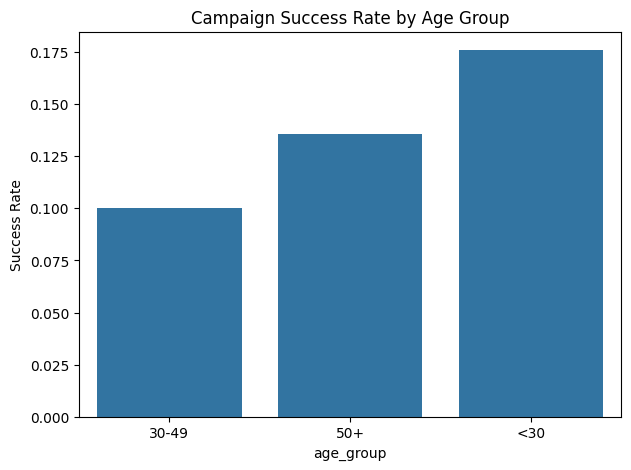

In [17]:
from pyspark.sql.functions import when, col


import matplotlib.pyplot as plt
import seaborn as sns

df = df.withColumn("age_group", when(col("age") < 30, "<30")
                                .when((col("age") >= 30) & (col("age") < 50), "30-49")
                                .otherwise("50+"))

df = df.withColumn("response", (col("y") == "yes").cast("int"))

age_pdf = df.groupBy("age_group").avg("response").withColumnRenamed("avg(response)", "success_rate").toPandas()

plt.figure(figsize=(7, 5))
sns.barplot(data=age_pdf, x="age_group", y="success_rate")
plt.title("Campaign Success Rate by Age Group")
plt.ylabel("Success Rate")
plt.show()


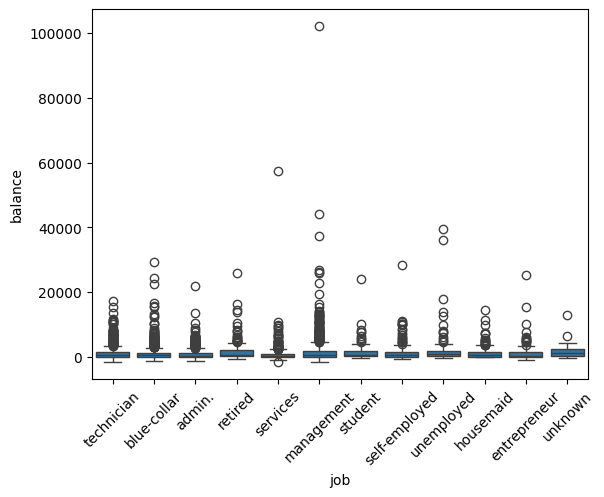

In [18]:
# Convert small subset to Pandas
pdf = df.select("job", "balance").sample(fraction=0.1).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=pdf, x="job", y="balance")
plt.xticks(rotation=45)
plt.show() 


In [19]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Convert categorical to numeric
indexer = StringIndexer(inputCol="y", outputCol="label")
df = indexer.fit(df).transform(df)

features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(df)

# Train-Test Split
train, test = data.randomSplit([0.7, 0.3], seed=42)

# Model
lr = LogisticRegression()
model = lr.fit(train)

# Evaluate
results = model.evaluate(test)
results.accuracy

0.8882797451474292